In [1]:
import pandas as pd
import seaborn as sns
import math
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [2]:
df_all = pd.read_csv('data/everything.csv')
df_unemployement=pd.read_csv('data/UnemployeementRate.csv')

C:\Users\Jacob\AppData\Local\Temp\ipykernel_73712\621901240.py:1: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('data/everything.csv')


In [3]:
df_unemployement = df_unemployement.rename(columns = {'Country Code':'Country_Code'})

In [4]:
df_growth = df_all.query('Variable.str.startswith("GDP growth") and Sex.str.startswith("T")')

In [5]:
df_growth = df_growth.assign(Change = 0)
changes=[]

for index in range(len(df_growth)):
    
    if math.isnan(df_growth.iloc[index].Year):
        changes.append(np.nan)
        continue
        
    year = int(df_growth.iloc[index].Year)
    prevYear = str(year-1)
    year = str(year)
    country = df_growth.iloc[index].LOCATION
    if country.startswith("XKO"):
        changes.append(np.nan)
        continue
        
    temp = df_unemployement.query('Country_Code.str.startswith(@country)')
    nums = not math.isnan(temp[year].values[0]) and not math.isnan(temp[prevYear].values[0])
    
    if nums:
        change = temp[year]-temp[prevYear]
        # print(type(change))
        changes.append(change.values[0])
    else:
        changes.append(np.nan)

In [6]:
df_growth.Change = changes
df_growth = df_growth.dropna(subset=['Change'])
df_growth = df_growth.rename(columns={'Value':'GDP_change','Change':'unemployment_change'})

In [7]:
df_growth = df_growth.assign(okun_pred=lambda df_growth:-.3*df_growth.GDP_change+1.2)

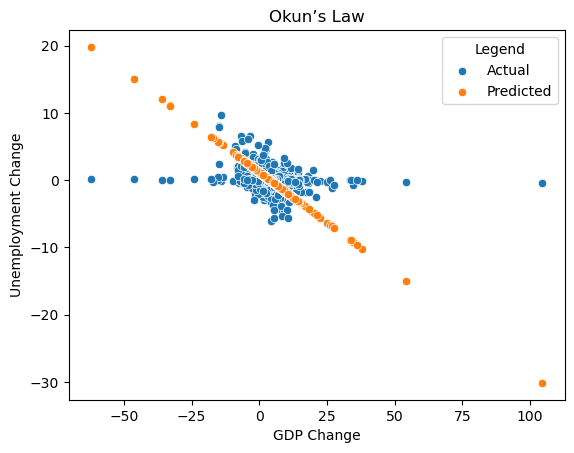

In [8]:
a = sns.scatterplot(data=df_growth, x = 'GDP_change',y='unemployment_change')
b = sns.scatterplot(data=df_growth, x = 'GDP_change', y= 'okun_pred')
a.set(xlabel ="GDP Change", ylabel = "Unemployment Change", title ='Okun’s Law')
a.legend(title='Legend', loc='upper right', labels=['Actual', 'Predicted'])

### What are some countries causing outliers?

In [9]:
ind = df_growth[['GDP_change']].idxmax()
print(ind.values[0])
df_growth.loc[ind]

116354


,LOCATION,Country,VAR,Variable,SEX,Sex,TIME,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,GDP_change,Flag Codes,Flags,unemployment_change,okun_pred
116354,LBY,Libya,NY_GDP_MKTP_KD_ZG,GDP growth,T,Total,2012,2012,GRWH,Growth rate,0,Units,NaN,NaN,104.4868,NaN,NaN,-0.415998,-30.14604


### Lets get rid of outliers

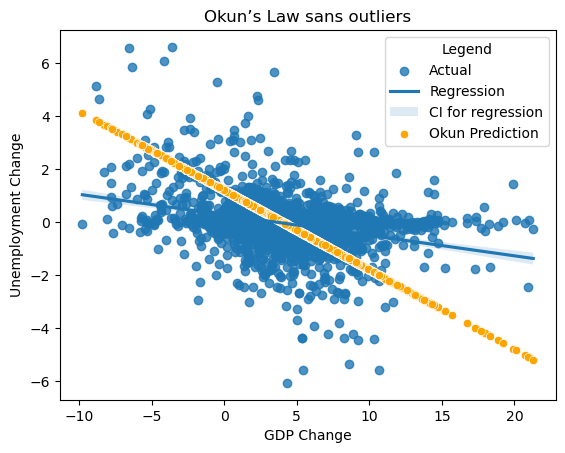

In [10]:
df_sub_growth = df_growth.query('GDP_change > -10 and GDP_change < 22')
a = sns.regplot(data=df_sub_growth, x = 'GDP_change',y='unemployment_change')
b = sns.scatterplot(data=df_sub_growth, x = 'GDP_change', y= 'okun_pred',color='orange')
# c = sns.regplot(data=df_sub_growth, x = 'GDP_change',y='unemployment_change')
a.set(xlabel ="GDP Change", ylabel = "Unemployment Change", title ='Okun’s Law sans outliers')
a.legend(title='Legend', loc='upper right', labels=['Actual', 'Regression','CI for regression' ,'Okun Prediction'])

In [11]:
print(r2_score(df_sub_growth['unemployment_change'],df_sub_growth['okun_pred']))

X = df_sub_growth[['GDP_change']]
Y = df_sub_growth['unemployment_change']
lm = LinearRegression()
lm.fit(X,Y)
print(lm.score(X,Y))
print('So a better model would be: unemployment change = ',lm.coef_[0],'* GDP change +',lm.intercept_)

-0.7020856359415033
0.0964352962420868
So a better model would be: unemployment change =  -0.07740200182094471 * GDP change + 0.2742088163731513
